In [1]:
# %load_ext autotime

In [2]:
from init import *
import os, scipy, salem
os.environ['PROJ_LIB']='/home/pankaj/.local/Anaconda3/share/proj/'
from tqdm import tqdm
import xesmf as xe
import io, imageio, geopandas as gpd

In [3]:
def convert_profile_to_column(con, met, const = 2.120e22):
    Ak = np.array([0.000000e+00, 4.804826e-02, 6.593752e+00, 1.313480e+01, 1.961311e+01, 2.609201e+01,
    3.257081e+01, 3.898201e+01, 4.533901e+01, 5.169611e+01, 5.805321e+01, 6.436264e+01,
    7.062198e+01, 7.883422e+01, 8.909992e+01, 9.936521e+01, 1.091817e+02, 1.189586e+02,
    1.286959e+02, 1.429100e+02, 1.562600e+02, 1.696090e+02, 1.816190e+02, 1.930970e+02,
    2.032590e+02, 2.121500e+02, 2.187760e+02, 2.238980e+02, 2.243630e+02, 2.168650e+02,
    2.011920e+02, 1.769300e+02, 1.503930e+02, 1.278370e+02, 1.086630e+02, 9.236572e+01,
    7.851231e+01, 6.660341e+01, 5.638791e+01, 4.764391e+01, 4.017541e+01, 3.381001e+01,
    2.836781e+01, 2.373041e+01, 1.979160e+01, 1.645710e+01, 1.364340e+01, 1.127690e+01,
    9.292942e+00, 7.619842e+00, 6.216801e+00, 5.046801e+00, 4.076571e+00, 3.276431e+00,
    2.620211e+00, 2.084970e+00, 1.650790e+00, 1.300510e+00, 1.019440e+00, 7.951341e-01,
    6.167791e-01, 4.758061e-01, 3.650411e-01, 2.785261e-01, 2.113490e-01, 1.594950e-01,
    1.197030e-01, 8.934502e-02, 6.600001e-02, 4.758501e-02, 3.270000e-02, 2.000000e-02,
    1.000000e-02])

    Bk = np.array([1.000000e+00, 9.849520e-01, 9.634060e-01, 9.418650e-01, 9.203870e-01, 8.989080e-01,
    8.774290e-01, 8.560180e-01, 8.346609e-01, 8.133039e-01, 7.919469e-01, 7.706375e-01,
    7.493782e-01, 7.211660e-01, 6.858999e-01, 6.506349e-01, 6.158184e-01, 5.810415e-01,
    5.463042e-01, 4.945902e-01, 4.437402e-01, 3.928911e-01, 3.433811e-01, 2.944031e-01,
    2.467411e-01, 2.003501e-01, 1.562241e-01, 1.136021e-01, 6.372006e-02, 2.801004e-02,
    6.960025e-03, 8.175413e-09, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
    0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
    0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
    0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
    0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
    0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
    0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
    0.000000e+00])

    ntim, nlev, nlat, nlon = con.shape
    nak = len(Ak)
    
    Ak = Ak.reshape((1, nak, 1, 1))
    Bk = Bk.reshape((1, nak, 1, 1)) 
    
    pedge = Ak + Bk * met['Met_PSC2WET'].values.reshape(ntim, 1, nlat, nlon)
    delp = -1*np.diff(pedge, axis=1) 
    col  = (const * con * delp).sum('lev')  # sum along levels
    col.attrs['long_name'] = 'Total column'
    col.attrs['units'] = 'mol/cm$^2$'
    return col 

class Animation():
    def __init__(self, data, proj=None):
        self.data = data       
        self.proj = proj
        self.vmin = self.data.min().values
        self.vmax = self.data.max().values
        self.xmin = self.data.lon.min().values
        self.xmax = self.data.lon.max().values
        self.ymin = self.data.lat.min().values
        self.ymax = self.data.lat.max().values
        
    def plot_map(self, time):
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        if self.proj:
            m = Basemap(ax=ax, **self.proj)
        else:          
            m = Basemap(projection='cyl', ax=ax)
        im = self.data.isel(time=time).plot(ax=ax, vmin=self.vmin, \
                                            vmax=self.vmax)
        #m.etopo(scale=0.5, aspect='auto')
        m.drawmapboundary(color='w')
        m.drawcoastlines(color='white')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim([self.xmin, self.xmax])
        ax.set_ylim([self.ymin, self.ymax])
        buf = io.BytesIO()
        plt.savefig(buf, bbox_inches='tight')
        buf.seek(0)
        im = imageio.imread(buf) 
        buf.close()
        plt.close()
        return im
    
    def make_animation(self, outfile="test.gif", fps=20):
        with imageio.get_writer(outfile, mode='I', fps=fps) as writer:
            for time in tqdm(np.arange(len(self.data.time))):
                im = self.plot_map(time)
                writer.append_data(im)

In [4]:
model = 'standard_2x25'
species = 'SpeciesConc_CH2O'
shp = gpd.read_file('india/india.shp')
outdir = '/home/pankaj/iitm/Test/run/merra2_2x25_standard_with_ship/OutputDir/'
confiles = sorted(glob.glob(outdir + 'GEOSChem.SpeciesConc.2017*_0000z.nc4'))[:-1]
metfiles = sorted(glob.glob(outdir + 'GEOSChem.StateMet.2017*_0000z.nc4'))[:-1]
con = xr.open_mfdataset(confiles).sel(lon=slice(40,100), lat=slice(-10,40))
met = xr.open_mfdataset(metfiles).sel(lon=slice(40,100), lat=slice(-10,40))
col = convert_profile_to_column(con[species], met).resample(time='MS').mean('time')

In [5]:
# dates = pd.date_range('01-01-2017', '12-31-2017', freq='MS')
# files = glob.glob('/home/pankaj/iitm/Test/2017/HCHO17*.csv')
# obs = xr.Dataset()
# for filename, date in zip(files, dates):
#     tmp = pd.read_csv(filename)
#     lat = np.arange(-90, 90, 0.1)
#     lon = np.arange(-180, 180, 0.1)
#     obs[date] = xr.DataArray(tmp.values, coords=[lat, lon], dims=['lat', 'lon'])
# obs = obs.to_array('time', name=species)
# obs.to_dataset(name='observation').to_netcdf('obs.nc')
obs = xr.open_dataset('obs.nc')['observation']
obs = obs.sel(lon=slice(40,100), lat=slice(-10,40))

In [6]:
model_mean = col.salem.subset(shape=shp).mean(dim=['lat', 'lon'])
obser_mean = obs.salem.subset(shape=shp).mean(dim=['lat', 'lon'])

(array([6.15043466e+15, 6.07532878e+15, 7.11754522e+15, 5.82329139e+15,
        5.52884481e+15, 7.46584377e+15, 6.55056091e+15, 4.93854378e+15,
        4.99025667e+15, 6.17360933e+15, 7.28228129e+15, 6.77511086e+15]),
 array([4.93195855e+15, 5.49627402e+15, 6.20973268e+15, 7.66093679e+15,
        8.33396596e+15, 7.07396333e+15, 6.45458731e+15, 6.67679766e+15,
        6.86040743e+15, 7.29193614e+15]))

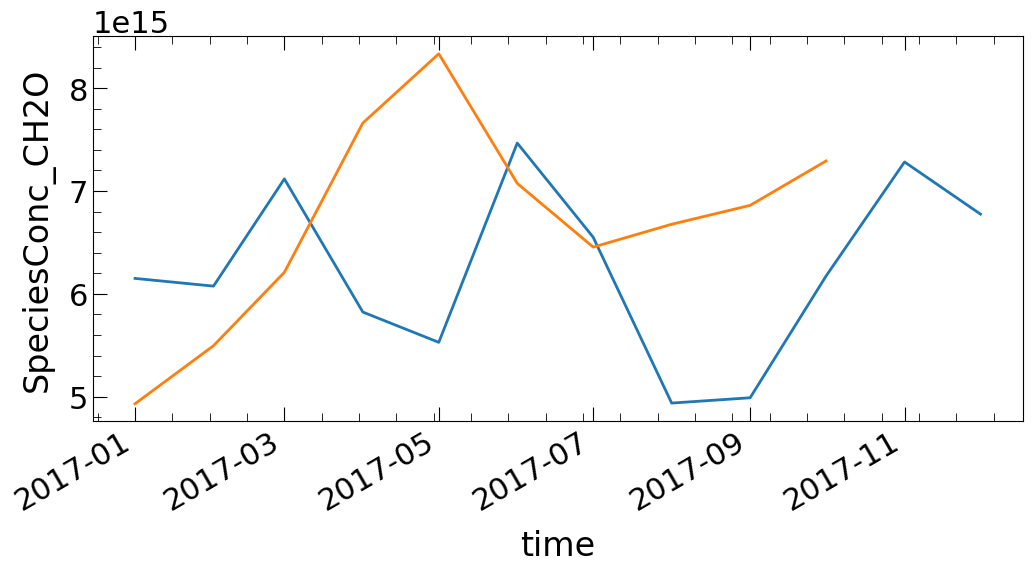

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
obser_mean.plot(ax=ax)
model_mean.plot(ax=ax)
ax.minorticks_on()
plt.show()

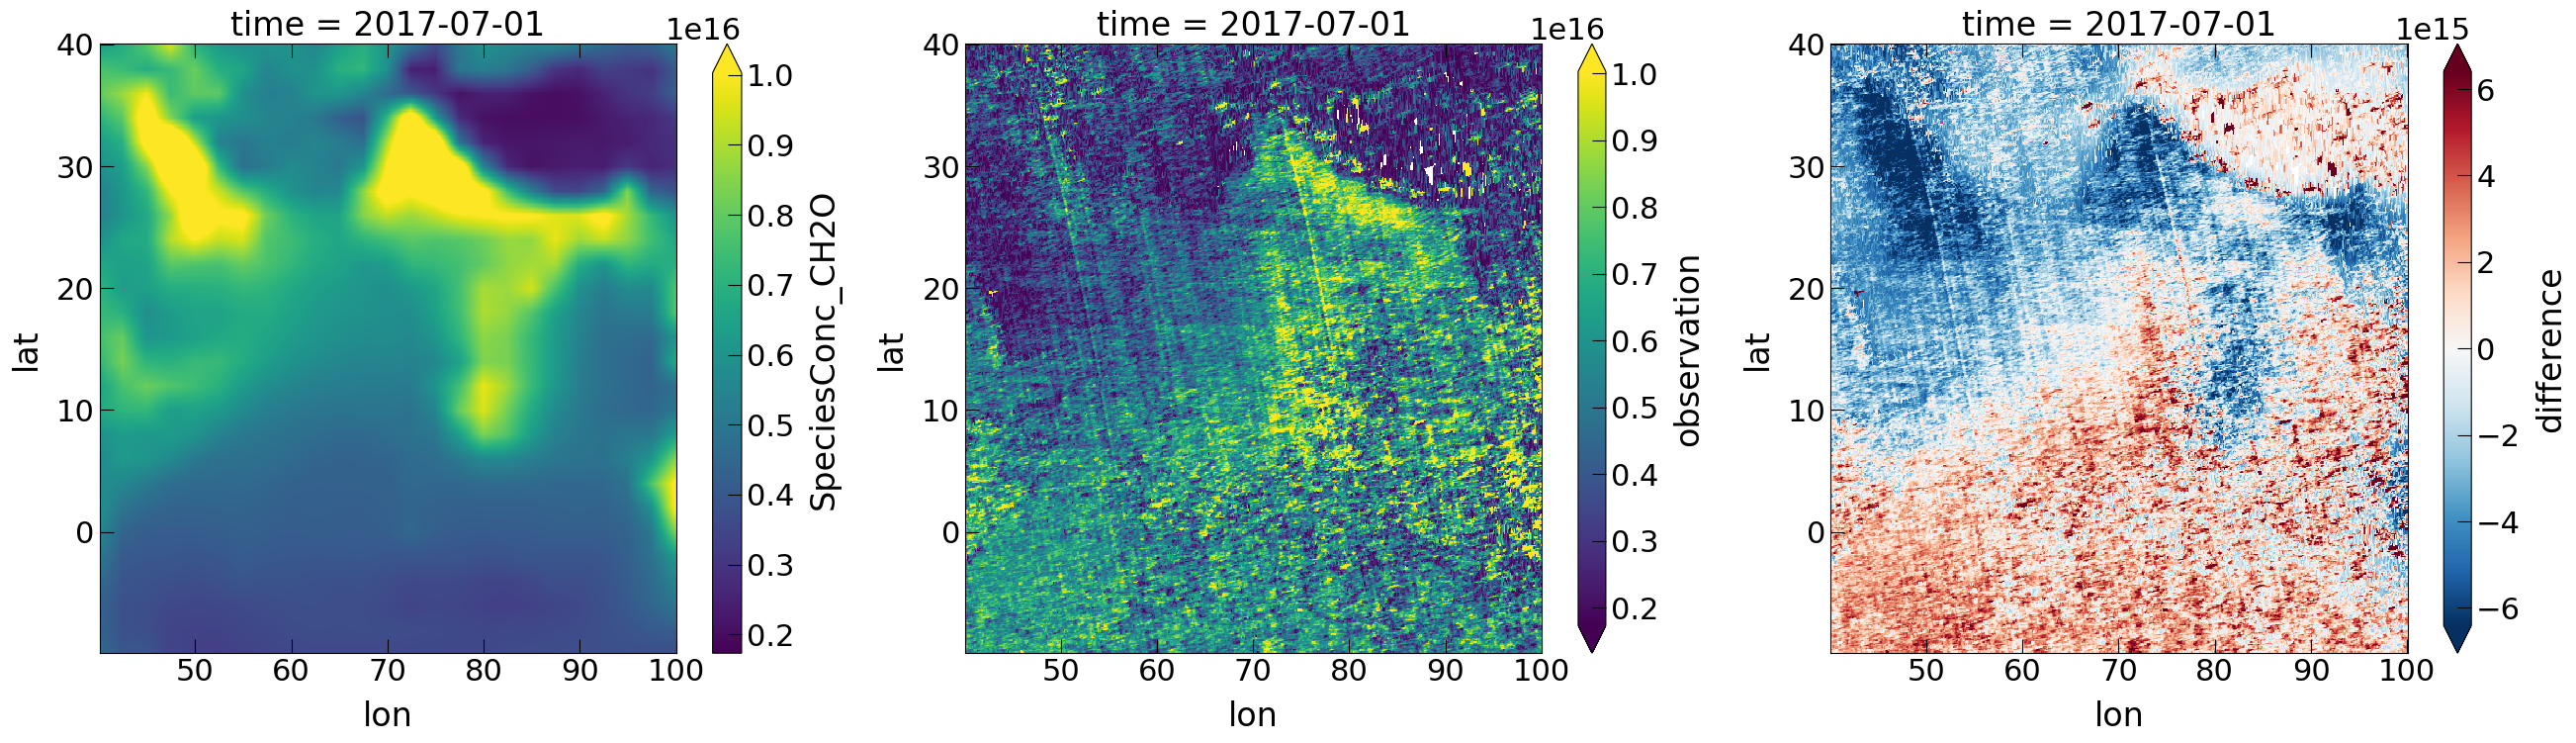

In [36]:
nobs = col.interp(lat=obs.lat, lon=obs.lon)
# obs = obs.interp(lat=obs.lat, lon=obs.lon)
diff = (obs - nobs) #/ obs
diff.name = 'difference'

vmin = obs.quantile(0.025)
vmax = obs.quantile(0.975)

fig, axes = plt.subplots(1, 3, figsize=(32, 8))
axes = axes.flatten()
for i, (ax, var) in enumerate(zip(axes, [nobs, obs, diff])):
    if i==2:
        var.sel(time='07-01-2017').plot(ax=ax, robust=True)
    else:      
        var.sel(time='07-01-2017').plot(ax=ax, robust=True, \
                                        vmin=vmin, vmax=vmax)
        
plt.savefig('2017-07-01.png', bbox_inches='tight')
plt.show()